In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *

In [2]:
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

## Parameters

In [3]:
DATE = '2023-04-21'
FREQ = 52
Tmat = 5

SAVEDATA = True

## Load Caps or Set Adhoc Vol

<Axes: xlabel='tenor'>

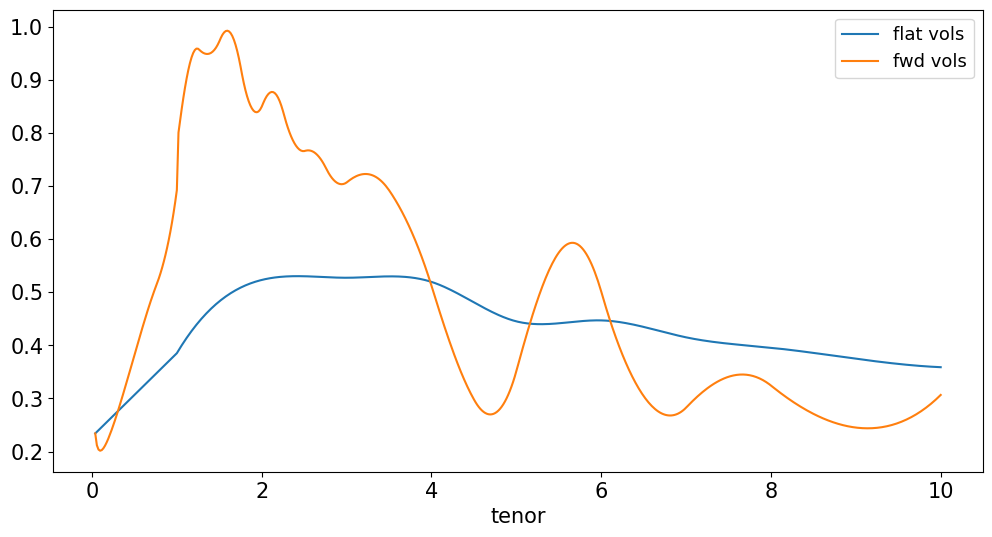

In [4]:
curves = pd.read_excel(f'../data/cap_curves_{DATE}_freq_{FREQ}.xlsx', sheet_name=f'rate curves {DATE}').set_index('tenor')
capcurves = flat_to_forward_vol(curves)
capcurves[['flat vols','fwd vols']].plot()

### Build Rate Tree

In [5]:
capcurves

,flat vols,caplet prices,fwd vols,cap prices
tenor,,,,
0.019231,NaN,NaN,NaN,NaN
0.038462,0.234111,0.001441,0.234111,0.001441
0.057692,0.237132,0.001988,0.211844,0.003429
0.076923,0.240152,0.002446,0.203757,0.005874
0.096154,0.243173,0.002860,0.201575,0.008734
...,...,...,...,...
9.923077,0.359418,0.016095,0.295082,8.233145
9.942308,0.359252,0.016248,0.297831,8.249393
9.961538,0.359093,0.016405,0.300663,8.265798


In [6]:
quotes = curves['discounts']*100

sigmas = capcurves['fwd vols']
sigmas.iloc[0] = sigmas.iloc[1]
sigmas.index = sigmas.index.to_numpy().round(6)

dt = 1/FREQ
tsteps = round(Tmat/dt)

theta, ratetree = estimate_theta(sigmas.iloc[:tsteps+1],quotes.iloc[:tsteps+1])

Completed: 0.4%
Completed: 0.8%
Completed: 1.1%
Completed: 1.5%
Completed: 1.9%
Completed: 2.3%
Completed: 2.7%
Completed: 3.1%
Completed: 3.4%
Completed: 3.8%
Completed: 4.2%
Completed: 4.6%
Completed: 5.0%
Completed: 5.4%
Completed: 5.7%
Completed: 6.1%
Completed: 6.5%
Completed: 6.9%
Completed: 7.3%
Completed: 7.7%
Completed: 8.0%
Completed: 8.4%
Completed: 8.8%
Completed: 9.2%
Completed: 9.6%
Completed: 10.0%
Completed: 10.3%
Completed: 10.7%
Completed: 11.1%
Completed: 11.5%
Completed: 11.9%
Completed: 12.3%
Completed: 12.6%
Completed: 13.0%
Completed: 13.4%
Completed: 13.8%
Completed: 14.2%
Completed: 14.6%
Completed: 14.9%
Completed: 15.3%
Completed: 15.7%
Completed: 16.1%
Completed: 16.5%
Completed: 16.9%
Completed: 17.2%
Completed: 17.6%
Completed: 18.0%
Completed: 18.4%
Completed: 18.8%
Completed: 19.2%
Completed: 19.5%
Completed: 19.9%
Completed: 20.3%
Completed: 20.7%
Completed: 21.1%
Completed: 21.5%
Completed: 21.8%
Completed: 22.2%
Completed: 22.6%
Completed: 23.0%
Compl

In [7]:
discounts = quotes.loc[:Tmat]/100
discounts.index = discounts.index.to_numpy().round(6)
discounts.name = 'discount'

params = pd.concat([discounts,sigmas,theta],axis=1,join='inner')
params.index.name = 'maturity'
params.rename(columns={'fwd vols':'fwd vol'},inplace=True)

### Save Data

In [8]:
if SAVEDATA:
    outfile = f'../build_data/bdt_params_freq{FREQ}_{DATE}.xlsx'
    with pd.ExcelWriter(outfile) as writer:  
        params.to_excel(writer, sheet_name= 'parameters', index=True)